In [1]:
import pandas as pd
import numpy as np

In [2]:
cars = pd.read_csv('audi.csv', sep=';')
cars.head()

,brand,model,year,price,transmission,mileage,fuel_type
0,Audi,A1,2017,67875,Manualna,25323,Benzyna
1,Audi,A6,2016,89595,Automatyczna,58263,Diesel
2,Audi,A1,2016,59730,Manualna,48193,Benzyna
3,Audi,A4,2017,91224,Automatyczna,41765,Diesel
4,Audi,A3,2019,93939,Manualna,3215,Benzyna


In [3]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import r2_score,mean_squared_error

from scipy.stats import boxcox

import xgboost as xgb

import math

from joblib import dump, load


import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [5]:
cars.head()

cars = cars.drop('model', axis=1)

In [6]:
cars.shape

(60361, 6)

In [7]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60361 entries, 0 to 60360
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         60361 non-null  object
 1   year          60361 non-null  int64 
 2   price         60361 non-null  int64 
 3   transmission  60361 non-null  object
 4   mileage       60361 non-null  int64 
 5   fuel_type     60361 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.8+ MB


In [8]:
cars.describe()

,year,price,mileage
count,60361.000000,60361.000000,60361.000000
mean,2016.869187,83279.324945,40178.697818
std,2.239714,47139.603074,36259.860357
min,1970.000000,2687.000000,1.000000
25%,2016.000000,52676.000000,13560.000000
50%,2017.000000,72751.000000,30970.000000
75%,2019.000000,100455.000000,55546.000000
max,2060.000000,841639.000000,519818.000000


In [9]:
round(100*(cars[cars.columns].isnull().sum()/len(cars.index)),2)

brand           0.0
year            0.0
price           0.0
transmission    0.0
mileage         0.0
fuel_type       0.0
dtype: float64

In [10]:
cars.head()

,brand,year,price,transmission,mileage,fuel_type
0,Audi,2017,67875,Manualna,25323,Benzyna
1,Audi,2016,89595,Automatyczna,58263,Diesel
2,Audi,2016,59730,Manualna,48193,Benzyna
3,Audi,2017,91224,Automatyczna,41765,Diesel
4,Audi,2019,93939,Manualna,3215,Benzyna


In [11]:
def plotBarGraph(df,xLabel,yLabel,graphSize=[]):
    barData = df.plot(kind="bar",figsize=graphSize)
    barData.set_xlabel(xLabel)
    barData.set_ylabel(yLabel)

    for p in barData.patches:
        barData.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2, p.get_height()), ha='center')

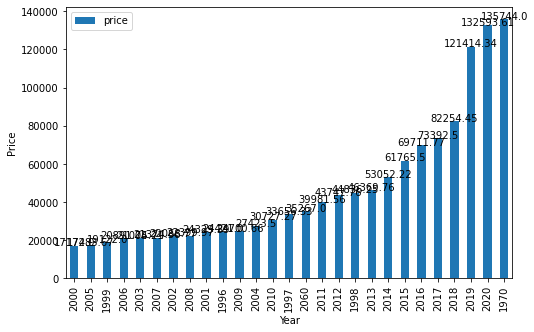

In [12]:
year_dist = pd.pivot_table(cars,index='year',values='price',aggfunc='mean').sort_values(by='price',ascending=True)
plotBarGraph(year_dist, 'Year', 'Price',[8,5])

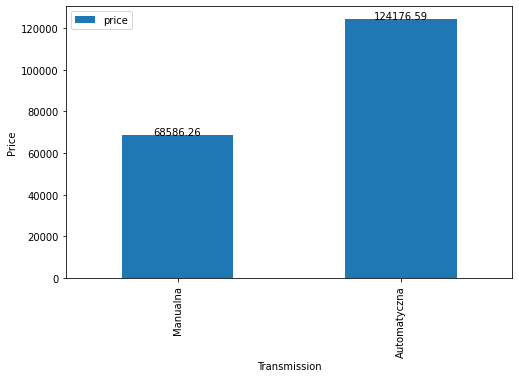

In [13]:
transmission_dist = pd.pivot_table(cars,index='transmission',values='price',aggfunc='mean').sort_values(by='price',ascending=True)
plotBarGraph(transmission_dist, 'Transmission', 'Price',[8,5])

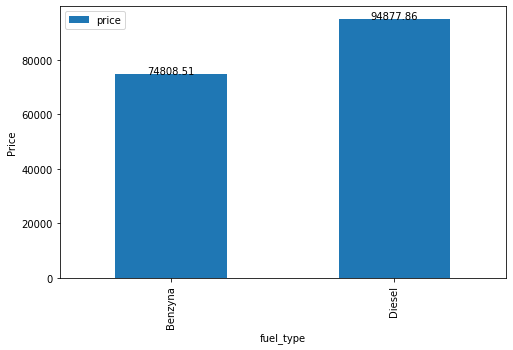

In [14]:
fuel_type_dist = pd.pivot_table(cars,index='fuel_type',values='price',aggfunc='mean').sort_values(by='price',ascending=True)
plotBarGraph(fuel_type_dist, 'fuel_type', 'Price',[8,5])

In [15]:
np.array(sorted(cars['mileage'].unique()))

array([     1,      3,      4, ..., 416820, 482803, 519818], dtype=int64)

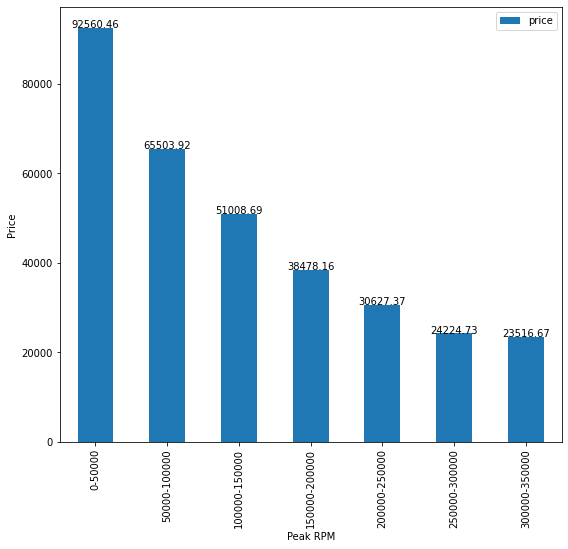

In [16]:
cars['mileage_b'] = pd.cut(cars['mileage'],[0, 50000,100000,150000,200000,250000,300000,350000],labels=['0-50000','50000-100000','100000-150000','150000-200000','200000-250000','250000-300000', '300000-350000'])
mileage_dist = pd.pivot_table(cars,index='mileage_b',values='price',aggfunc='mean')
plotBarGraph(mileage_dist, 'Peak RPM', 'Price',[9,8])

In [17]:
cars = cars.drop('mileage_b', axis=1)

In [18]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
car_num_cols = list(cars.select_dtypes(include=numerics).columns)
car_num_cols

['year', 'price', 'mileage']

In [19]:
car_cat_cols = list(cars.select_dtypes(exclude=numerics).columns)
car_cat_cols

['brand', 'transmission', 'fuel_type']

In [20]:
car_corr = cars[car_num_cols].corr()
car_corr

,year,price,mileage
year,1.000000,0.477870,-0.731945
price,0.477870,1.000000,-0.407581
mileage,-0.731945,-0.407581,1.000000


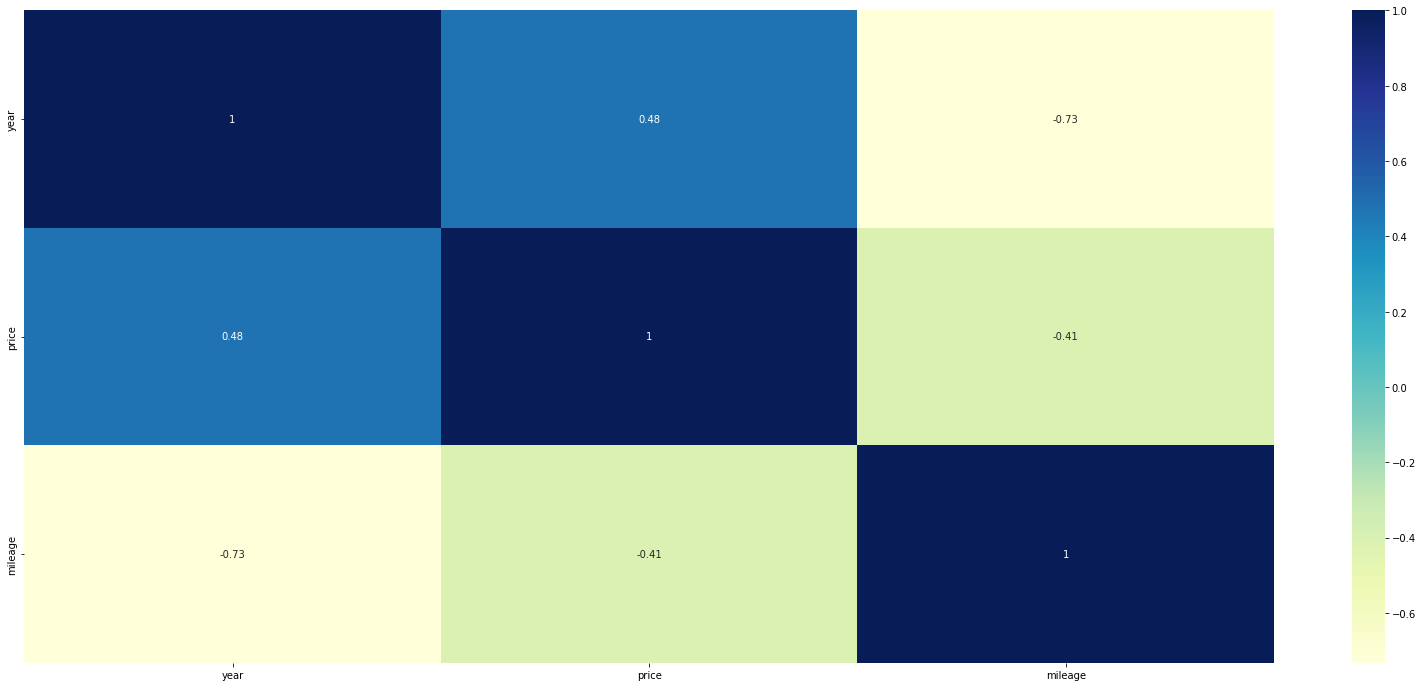

In [21]:
plt.figure(figsize=(28,12))

# plotting heatmap
sns.heatmap(car_corr, cmap="YlGnBu", annot=True)
plt.show()

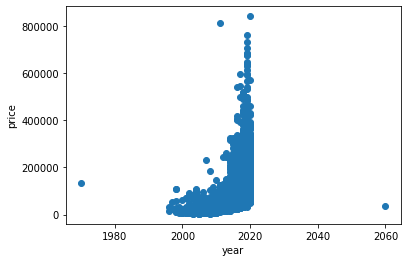

In [22]:
plt.xlabel("year")
plt.ylabel("price")
plt.scatter(cars['year'],cars['price'])

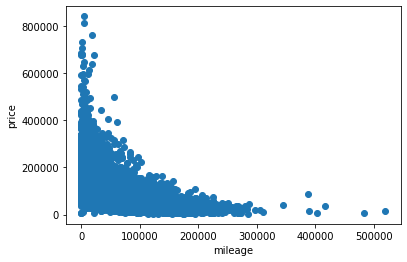

In [23]:
plt.xlabel("mileage")
plt.ylabel("price")
plt.scatter(cars['mileage'],cars['price'])

In [24]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
ohe.fit(cars[car_cat_cols])
car_ohe = ohe.transform(cars[car_cat_cols])
car_df_ohe = pd.DataFrame(car_ohe, columns = ohe.get_feature_names(input_features = car_cat_cols))
car_df_ohe.head()

,brand_Audi,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Skoda,brand_Toyota,brand_Volkswagen,transmission_Automatyczna,transmission_Manualna,fuel_type_Benzyna,fuel_type_Diesel
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [25]:
dump(ohe, '../jupyter/ohe.joblib')

['../jupyter/ohe.joblib']

In [26]:
cars.head()

,brand,year,price,transmission,mileage,fuel_type
0,Audi,2017,67875,Manualna,25323,Benzyna
1,Audi,2016,89595,Automatyczna,58263,Diesel
2,Audi,2016,59730,Manualna,48193,Benzyna
3,Audi,2017,91224,Automatyczna,41765,Diesel
4,Audi,2019,93939,Manualna,3215,Benzyna


In [27]:
cars = cars.drop(list(car_cat_cols), axis=1)
cars = pd.concat([cars, car_df_ohe], axis=1)

In [28]:
cars.head()

,year,price,mileage,brand_Audi,brand_BMW,brand_Ford,brand_Hyundai,brand_Mercedes,brand_Skoda,brand_Toyota,brand_Volkswagen,transmission_Automatyczna,transmission_Manualna,fuel_type_Benzyna,fuel_type_Diesel
0,2017,67875,25323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2016,89595,58263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2016,59730,48193,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,2017,91224,41765,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2019,93939,3215,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [29]:
X=cars
y=cars.pop('price')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [31]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,train_size=0.5,random_state=42)

In [32]:
car_num_cols.remove('price')
scaler=StandardScaler()
scaler.fit(X_train[car_num_cols])

X_train[car_num_cols] = scaler.transform(X_train[car_num_cols])
X_test[car_num_cols] = scaler.transform(X_test[car_num_cols])

In [33]:
dump(scaler, '../jupyter/scaler.joblib')

['../jupyter/scaler.joblib']

In [34]:
xgb_reg = xgb.XGBRegressor(n_jobs = -1) # default paramters
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [35]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
y_pred_test = xgb_reg.predict(X_test)

r2score = round(r2_score(y_pred_test,y_test),2)*100

In [37]:
print("R2 Score on Test Data is : ",r2score)

R2 Score on Test Data is :  50.0


In [38]:
mse = mean_squared_error(y_test, y_pred_test)

rmse = round(math.sqrt(mse),2)

print(rmse)

27620.9


In [39]:
params = {
        'n_estimators' : [100, 200, 500, 750],
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
param_comb = 100

random_search = RandomizedSearchCV(xgb_reg, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=folds, verbose=3, random_state=42)

random_search.fit(X_val, y_val)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          enable_categorical=False, gamma=0,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimato...
                                          subsample=1, tree_method='exact',
                                          validate_parameters=1,
       

In [40]:
print('We can get score of :',random_search.best_score_,' using',random_search.best_params_)

We can get score of : 0.6715851373914169  using {'subsample': 0.6, 'n_estimators': 750, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}


In [41]:
xgb_reg_hpt = xgb.XGBRegressor(subsample=0.6, n_estimators=500, min_child_weight=1,max_depth=4,
                               learning_rate=0.01, gamma=1, colsample_bytree=0.6, n_jobs = -1)
xgb_reg_hpt.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'enable_categorical': False,
 'gamma': 1,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_delta_step': None,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
xgb_reg_hpt.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
y_pred_test_hpt = xgb_reg_hpt.predict(X_test)

r2score = round(r2_score(y_pred_test_hpt,y_test),2)*100

In [44]:
print("R2 score on Test Data is : ",r2score)

R2 score on Test Data is :  45.0


In [45]:
mse = mean_squared_error(y_test, y_pred_test_hpt)

rmse = round(math.sqrt(mse),2)

print(rmse)

27503.22


In [46]:
dump(xgb_reg_hpt, '../jupyter/XGBoost.joblib')

['../jupyter/XGBoost.joblib']

In [47]:
y_train_pred = xgb_reg_hpt.predict(X_train)
y_test_pred = xgb_reg_hpt.predict(X_test)

r2_train_lr = r2_score(y_train, y_train_pred)
print("R2 score on Training data : ",round(r2_train_lr,2)*100)

r2_test_lr = r2_score(y_test, y_test_pred)
print("R2 score on Test data : ",round(r2_test_lr,2)*100)

R2 score on Training data :  68.0
R2 score on Test data :  67.0


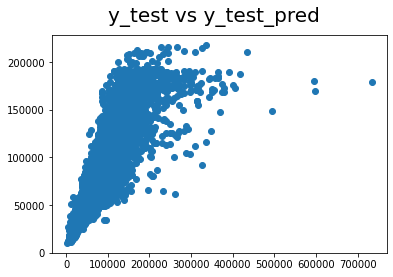

In [48]:
fig = plt.figure()
fig.suptitle('y_test vs y_test_pred',fontsize=20)
plt.scatter(y_test,y_test_pred)